In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
import requests as rq
import io

In [2]:
url_1 = 'https://github.com/enriqfl/EstadisticaProyecto/raw/main/freeGames.csv'
url_2 = 'https://github.com/enriqfl/EstadisticaProyecto/raw/main/paidGames.csv'
url_3 = 'https://github.com/enriqfl/EstadisticaProyecto/raw/main/ownersGames.csv'

In [3]:
col_id = 'AppID'
col_price = 'Price'
col_owners = 'Estimated owners'
file_paid_response = rq.get(url_2)
file_free_response = rq.get(url_1)
file_owners_response = rq.get(url_3)

try:
    df_paid_price = pd.read_csv(io.StringIO(file_paid_response.text))
    df_free_price = pd.read_csv(io.StringIO(file_free_response.text))
    df_owners_data = pd.read_csv(io.StringIO(file_owners_response.text))

    # Limpieza

    # Eliminar nulls
    df_paid_price.dropna(subset=[col_id], inplace=True)
    df_free_price.dropna(subset=[col_id], inplace=True)
    df_owners_data.dropna(subset=[col_id], inplace=True)

    # Eliminar duplicados
    df_paid_price.drop_duplicates(subset=[col_id], inplace=True)
    df_free_price.drop_duplicates(subset=[col_id], inplace=True)
    df_owners_data.drop_duplicates(subset=[col_id], inplace=True)

except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo {e.filename}.")

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# col_id = 'AppID'
# col_price = 'Price'
# col_owners = 'Estimated owners'

# file_paid = '/content/drive/MyDrive/ProyectoFinal/paidGames.csv'
# file_free = '/content/drive/MyDrive/ProyectoFinal/freeGames.csv'
# file_owners = '/content/drive/MyDrive/ProyectoFinal/ownersGames.csv'

# try:
#    df_paid_price = pd.read_csv(file_paid)
#    df_free_price = pd.read_csv(file_free)
#    df_owners_data = pd.read_csv(file_owners)

# except FileNotFoundError as e:
#     print(f"Error: No se encontró el archivo {e.filename}.")

In [5]:
# Unir datos de propietarios con los juegos de pago
df_paid = pd.merge(df_paid_price, df_owners_data, on=col_id)

print(df_paid.isnull().sum())
print(df_paid.shape)

AppID               0
Price               0
Estimated owners    0
dtype: int64
(2490, 3)


In [6]:
# Une los datos de propietarios con los juegos gratuitos
df_free = pd.merge(df_free_price, df_owners_data, on=col_id)

print(df_free.isnull().sum())
print(df_free.shape)

AppID               0
Price               0
Estimated owners    0
dtype: int64
(107872, 3)


In [7]:
# Crear dataset completo

# Añadimos una columna para saber qué es qué
df_paid['Tipo'] = 'De Pago'
df_free['Tipo'] = 'Gratuito'

# Combinamos ambos en un solo DataFrame
df_full = pd.concat([df_paid, df_free])

print(df_full.isnull().sum())
print(df_full.shape)

AppID               0
Price               0
Estimated owners    0
Tipo                0
dtype: int64
(110362, 4)


In [8]:
totalPago = len(df_full)
caros = len(df_full[df_full['Price'] >= 50])
print((caros/totalPago)*100)


# Como los juegos con precio > 50 usd representan una cantidad pequeña de nuestros datos y no tan significativa,
# vamos a trabajar únicamente con los datos significativos (juegos con precio < 50 usd)

0.038056577445135104


In [39]:
df_sign = df_full[df_full['Price'] <= 50].copy()
print(df_sign.shape)

precio_max = df_sign[col_price].max()
precio_min = df_sign[col_price].min()
rango = precio_max - precio_min
print(f"Precio Mínimo: ${precio_min}")
print(f"Precio Máximo: ${precio_max}")
print(f"Rango de precios: ${rango}")

(110339, 4)
Precio Mínimo: $0
Precio Máximo: $50
Rango de precios: $50
0         10
1         25
2         15
3         10
4         20
          ..
107867     0
107868     0
107869     0
107870     0
107871     0
Name: Price, Length: 110339, dtype: int64


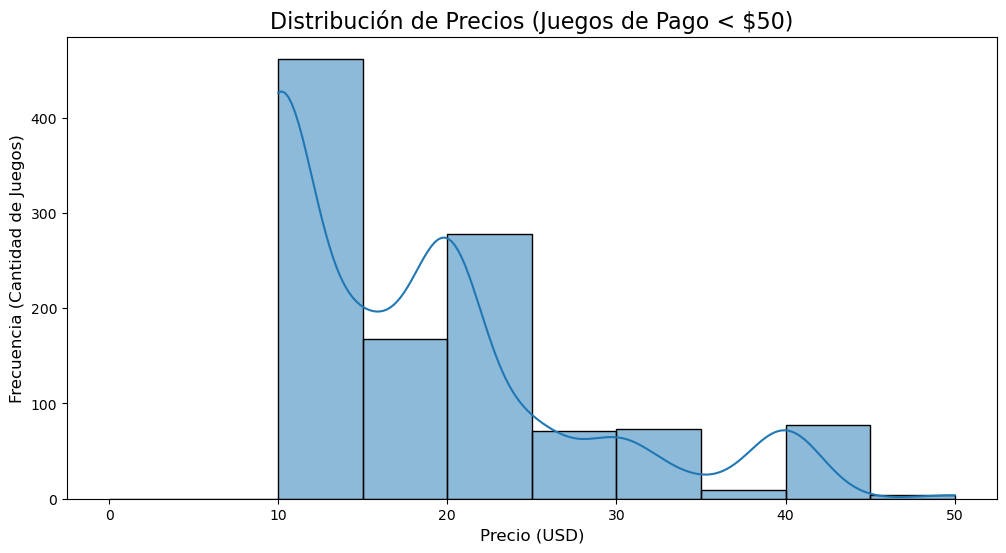

In [51]:
# TRANSFORMACIÓN ESTADÍSTICA

# Convertir las columnas a numérico
df_sign[col_owners] = pd.to_numeric(df_sign[col_owners], errors='coerce')
df_sign[col_price] = pd.to_numeric(df_sign[col_price], errors='coerce')


# Limpiar datos nulos o ceros en owners
df_sign = df_sign.dropna(subset=[col_owners])
df_sign = df_sign[df_sign[col_owners] > 0]

df_paid = df_sign[df_sign[col_price] > 0].copy()
df_free = df_sign[df_sign[col_price] == 0].copy()


# Aplicar logaritmo base 10 para normalizar la distribución de popularidad
df_paid['log_owners'] = np.log10(df_paid[col_owners])
df_plot = df_paid[df_paid[col_price] <= 50].copy()
plt.figure(figsize=(12, 6))

sns.histplot(df_plot[col_price], kde=True, bins=range(0, 55, 5))
plt.title('Distribución de Precios (Juegos de Pago < $50)', fontsize=16)
plt.xlabel('Precio (USD)', fontsize=12)
plt.ylabel('Frecuencia (Cantidad de Juegos)', fontsize=12)
plt.show()

In [41]:
# Ver juegos baratos (por ejemplo, menos de 10 dólares)
juegos_baratos = df_paid[df_paid[col_price] < 10]

# Muestra los primeros 10 para confirmar visualmente
print(juegos_baratos[[col_price]].head(10)) # Asumiendo que tienes una columna 'Title'

Empty DataFrame
Columns: [Price]
Index: []


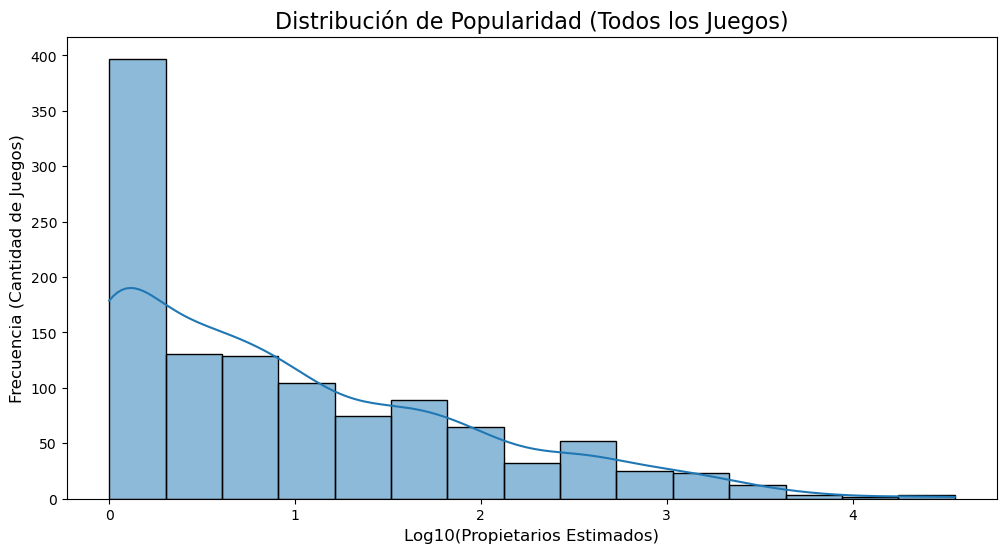

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(df_paid['log_owners'], kde=True, bins=15)
plt.title('Distribución de Popularidad (Todos los Juegos)', fontsize=16)
plt.xlabel('Log10(Propietarios Estimados)', fontsize=12)
plt.ylabel('Frecuencia (Cantidad de Juegos)', fontsize=12)
plt.show()

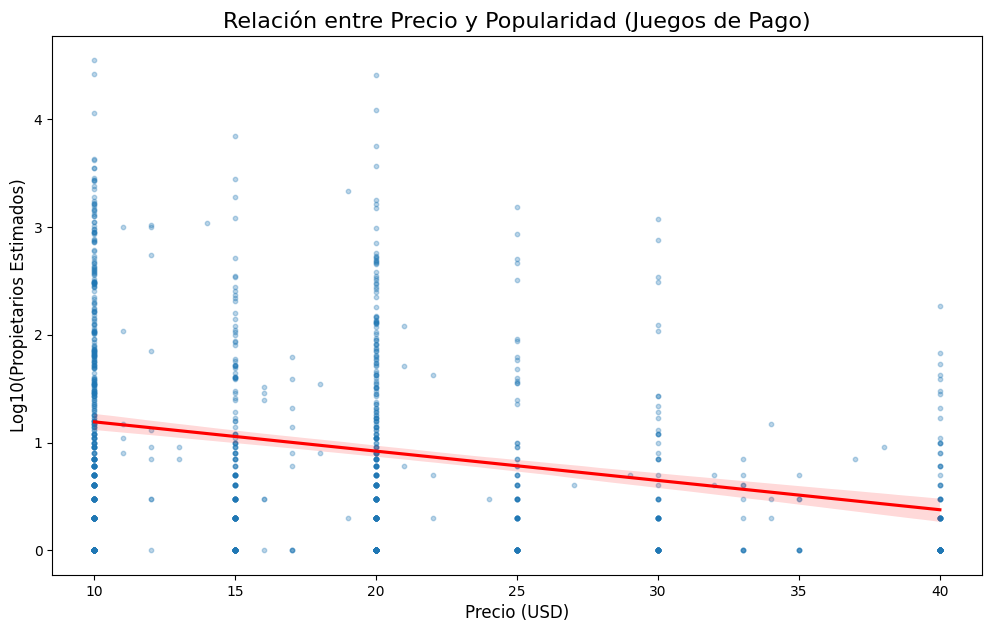

In [364]:
plt.figure(figsize=(12, 7))

# Usamoa el dataframe filtrado para una mejor visualización
sns.regplot(
    data=df_paid_filtrado,
    x=col_price,
    y='log_owners',
    scatter_kws={'alpha':0.3, 's':10}, # Puntos más transparentes
    line_kws={'color':'red'}          # Línea de regresión roja
)

plt.title('Relación entre Precio y Popularidad (Juegos de Pago)', fontsize=16)
plt.xlabel('Precio (USD)', fontsize=12)
plt.ylabel('Log10(Propietarios Estimados)', fontsize=12)
plt.show()

In [365]:
plt.figure(figsize=(10, 7))
sns.boxplot(
    data=df_full,
    x='Tipo',
    y='log_owners',
    palette=['skyblue', 'salmon'],
    hue='Tipo',
    legend=False
)
plt.title('Comparación de Popularidad: Gratuito vs. De Pago', fontsize=16)
plt.xlabel('Modelo de Negocio', fontsize=12)
plt.ylabel('Log10(Propietarios Estimados)', fontsize=12)
plt.show()

ValueError: Could not interpret value `log_owners` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x700 with 0 Axes>

In [ ]:
'''
Seguir haciendo Estadística Descriptiva:
Tednencia central: Media, mediana, moda
Dispersión: Varianza, D.Estandar, Rango, C.V., D.Media.

Kurtuosis, asímetria, Outlaires
'''

In [ ]:
'''
Tendencia Central:
'''

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('===ESTADÍSTICA DESCRIPTIVA - JUEGOS DE STEAM===', fontsize=20, fontweight='bold', y=0.995)
# SUBPLOT 1: Precios con Tendencia Central
precios = df_paid_filtrado[col_price].dropna()
ax1 = axes[0]

ax1.hist(precios, bins=20, alpha=0.7, color='skyblue', edgecolor='black', density=True)

# Líneas de tendencia central
media_precio = precios.mean()
mediana = precios.median()
moda = precios.mode().values[0]

ax1.axvline(media_precio, color='red', linestyle='--', linewidth=2, label=f'Media: ${media_precio:.2f}')
ax1.axvline(mediana, color='green', linestyle='--', linewidth=2, label=f'Mediana: ${mediana:.2f}')
ax1.axvline(moda, color='orange', linestyle='--', linewidth=2, label=f'Moda: ${moda:.2f}')

# Curva KDE
kde = gaussian_kde(precios)
x_range = np.linspace(precios.min(), precios.max(), 100)
ax1.plot(x_range, kde(x_range), 'k-', linewidth=2, label='Densidad (KDE)')

ax1.set_title('PRECIOS - Tendencia Central', fontsize=14, fontweight='bold')
ax1.set_xlabel('Precio (USD)', fontsize=12)
ax1.set_ylabel('Densidad', fontsize=12)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)


# SUBPLOT 2: POPULARIDAD con Tendencia Central
ax2 = axes[1]
popularidad = df_full['log_owners'].dropna()

# Configurar bins más apropiados para datos logarítmicos
num_bins = min(30, len(popularidad) // 20)  # Ajustar automáticamente
num_bins = max(10, num_bins)  # Mínimo 10 bins

#Elegir una regla para los bins
'''
# Regla de Sturges (la más básica)
num_bins_sturges = int(np.ceil(np.log2(len(popularidad))) + 1)
'''

# Mejorar el histograma
n, bins, patches = ax2.hist(popularidad, bins=num_bins, alpha=0.7,
                           color='lightcoral', edgecolor='black',
                           linewidth=0.8, density=True)

# Mejor gradiente de color en las barras
import matplotlib.cm as cm
cmap = cm.get_cmap('Reds')
norm = plt.Normalize(bins.min(), bins.max())
for patch, bin_edge in zip(patches, bins[:-1]):
    patch.set_facecolor(cmap(norm(bin_edge)))

# Calcular estadísticas
media_pop = popularidad.mean()
mediana_pop = popularidad.median()


# Mejorar líneas verticales
ax2.axvline(media_pop, color='red', linestyle='--', linewidth=2.5,
            alpha=0.9, label=f'Media: {media_pop:.2f}')
ax2.axvline(mediana_pop, color='green', linestyle='--', linewidth=2.5,
            alpha=0.9, label=f'Mediana: {mediana_pop:.2f}')
# KDE mejorado
kde_pop = gaussian_kde(popularidad)
x_range_pop = np.linspace(popularidad.min(), popularidad.max(), 200)
ax2.plot(x_range_pop, kde_pop(x_range_pop), 'k-', linewidth=2.5,
         alpha=0.8, label='Densidad KDE')


# Configurar título y etiquetas
ax2.set_title('Distribución de Popularidad (Log10 Propietarios)',
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Log10(Número de Propietarios)', fontsize=12, labelpad=10)
ax2.set_ylabel('Densidad de Probabilidad', fontsize=12, labelpad=10)



stats_text = f'''Estadísticas:
N = {len(popularidad):,}
Media = {media_pop:.2f}
Mediana = {mediana_pop:.2f}

(≈{10**media_pop:,.0f} propietarios promedio)'''

ax2.text(0.98, 0.98, stats_text, transform=ax2.transAxes,
         fontsize=9, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Mejorar leyenda
ax2.legend(loc='center right', fontsize=9, framealpha=0.9,
          fancybox=True, shadow=True)

# Mejorar grid
ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)


ax2.set_xlim(popularidad.min() - 0.1, popularidad.max() + 0.1)

# Agregar anotación de transformación logarítmica
ax2.annotate('*Valores en escala logarítmica base 10',
            xy=(0.5, -0.15), xycoords='axes fraction',
            ha='center', fontsize=8, style='italic')






In [ ]:

# CALCULAR MEDIDAS DE DISPERSIÓN



# 1. RANGO
rango = precios.max() - precios.min()

# 2. DESVIACIÓN ESTÁNDAR (D.E.)
media = precios.mean()
desv_est = precios.std()


# 3. COEFICIENTE DE VARIACIÓN (C.V.)
cv = (desv_est / media) * 100
if cv < 30:
    interpretacion = "BAJA variabilidad - Precios homogéneos"
elif cv < 60:
    interpretacion = "MODERADA variabilidad - Precios medianamente dispersos"
else:
    interpretacion = "ALTA variabilidad - Precios muy heterogéneos"


# 4. DESVIACIÓN MEDIA (D.M.)
desv_media = np.mean(np.abs(precios - media))


# 5. VARIANZA
varianza = precios.var()


# COMPARACIÓN
print(f"\n COMPARACIÓN DE MEDIDAS:")
print(f"   Rango:           ${rango:.2f}  (usa solo 2 valores)")
print(f"   Desv. Media:     ${desv_media:.2f}  (promedio de distancias)")
print(f"   Desv. Estándar:  ${desv_est:.2f}  (raíz del promedio de distancias²)")
print(f"   C.V.:            {cv:.1f}%  (dispersión relativa)")
print(f"   Interpretación del CV: {interpretacion}")

print("\n" + "="*80)


# HISTOGRAMAS CON MEDIDAS DE DISPERSIÓN


fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

fig.suptitle(' MEDIDAS DE DISPERSIÓN - ANÁLISIS VISUAL',
             fontsize=20, fontweight='bold', y=0.98)

# ----------------------------------------------------------------------------
# GRÁFICO 1: RANGO
# ----------------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])

ax1.hist(precios, bins=25, alpha=0.7, color='skyblue', edgecolor='black')

# Marcar mínimo y máximo
ax1.axvline(precios.min(), color='red', linestyle='--', linewidth=2.5,
            label=f'Mínimo: ${precios.min():.2f}')
ax1.axvline(precios.max(), color='darkred', linestyle='--', linewidth=2.5,
            label=f'Máximo: ${precios.max():.2f}')

# Zona del rango
ax1.axvspan(precios.min(), precios.max(), alpha=0.1, color='red')

ax1.set_title(f' RANGO = ${rango:.2f}', fontsize=14, fontweight='bold')
ax1.set_xlabel('Precio (USD)', fontsize=11)
ax1.set_ylabel('Frecuencia', fontsize=11)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Texto explicativo
textstr = f'Rango = Máx - Mín\n= ${precios.max():.2f} - ${precios.min():.2f}\n= ${rango:.2f}'
ax1.text(0.98, 0.65, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# ----------------------------------------------------------------------------
# GRÁFICO 2: DESVIACIÓN ESTÁNDAR
# ----------------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])

ax2.hist(precios, bins=25, alpha=0.7, color='lightcoral', edgecolor='black')

ax2.axvline(media, color='black', linestyle='-', linewidth=2.5,
            label=f'Media: ${media:.2f}')

# Zonas de desviación estándar
ax2.axvspan(media - desv_est, media + desv_est, alpha=0.2, color='yellow',
            label=f'±1 D.E. (68%): ${desv_est:.2f}')
ax2.axvspan(media - 2*desv_est, media + 2*desv_est, alpha=0.1, color='orange',
            label=f'±2 D.E. (95%)')

ax2.set_title(f'DESVIACIÓN ESTÁNDAR = ${desv_est:.2f}',fontsize=14, fontweight='bold')
ax2.set_xlabel('Precio (USD)', fontsize=11)
ax2.set_ylabel('Frecuencia', fontsize=11)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# Marcar límites
ax2.axvline(media - desv_est, color='gold', linestyle=':', linewidth=2)
ax2.axvline(media + desv_est, color='gold', linestyle=':', linewidth=2)

# ----------------------------------------------------------------------------
# GRÁFICO 3: COEFICIENTE DE VARIACIÓN (Comparación)
# ----------------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 0])

# Calcular C.V. para ambas variables
cv_precio = (precios.std() / precios.mean()) * 100
cv_popularidad = (popularidad.std() / popularidad.mean()) * 100

categorias = ['Precios', 'Popularidad']
cvs = [cv_precio, cv_popularidad]
colores = ['salmon' if cv > 60 else 'lightgreen' for cv in cvs]

bars = ax3.bar(categorias, cvs, color=colores, edgecolor='black', linewidth=1.5, alpha=0.8)

# Añadir valores en las barras
for bar, cv in zip(bars, cvs):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{cv:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Línea de referencia
ax3.axhline(30, color='orange', linestyle='--', linewidth=2, label='30% (moderado)')
ax3.axhline(60, color='red', linestyle='--', linewidth=2, label='60% (alto)')

ax3.set_title('COEFICIENTE DE VARIACIÓN (C.V.)', fontsize=14, fontweight='bold')
ax3.set_ylabel('C.V. (%)', fontsize=11)
ax3.set_ylim(0, max(cvs) * 1.2)
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# Interpretación
if cv_precio > 60:
    interpretacion = "Alta heterogeneidad\nen precios"
else:
    interpretacion = "Precios consistentes"

ax3.text(0, cv_precio + 5, interpretacion, ha='center', fontsize=9,
         style='italic', color='darkred')

# ----------------------------------------------------------------------------
# GRÁFICO 4: DESVIACIÓN MEDIA vs DESVIACIÓN ESTÁNDAR
# ----------------------------------------------------------------------------
ax4 = fig.add_subplot(gs[1, 1])

ax4.hist(precios, bins=25, alpha=0.7, color='plum', edgecolor='black', density=True)

# Media
ax4.axvline(media, color='black', linestyle='-', linewidth=2.5, label=f'Media: ${media:.2f}')

# Desviación Media
ax4.axvspan(media - desv_media, media + desv_media, alpha=0.2, color='blue',
            label=f'±D.M.: ${desv_media:.2f}')

# Desviación Estándar
ax4.axvspan(media - desv_est, media + desv_est, alpha=0.15, color='red',
            label=f'±D.E.: ${desv_est:.2f}')

ax4.set_title('DESVIACIÓN MEDIA vs D.E.', fontsize=14, fontweight='bold')
ax4.set_xlabel('Precio (USD)', fontsize=11)
ax4.set_ylabel('Densidad', fontsize=11)
ax4.legend(loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# Nota explicativa
textstr = f'D.M. = ${desv_media:.2f}\nD.E. = ${desv_est:.2f}\n\nD.E. > D.M.\n(por valores extremos)'
ax4.text(0.02, 0.98, textstr, transform=ax4.transAxes, fontsize=9,
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

# ----------------------------------------------------------------------------
# GRÁFICO 5: DISTRIBUCIÓN CON TODAS LAS MEDIDAS
# ----------------------------------------------------------------------------
ax5 = fig.add_subplot(gs[2, :])

# Histograma principal
n, bins, patches = ax5.hist(precios, bins=30, alpha=0.6, color='lightgreen',
                             edgecolor='black', density=True)

# KDE
from scipy.stats import gaussian_kde
kde = gaussian_kde(precios)
x_range = np.linspace(precios.min(), precios.max(), 300)
ax5.plot(x_range, kde(x_range), 'k-', linewidth=2.5, label='Densidad (KDE)')

# Media
ax5.axvline(media, color='red', linestyle='-', linewidth=3,
            label=f'Media: ${media:.2f}', zorder=5)

# Mediana
mediana = precios.median()
ax5.axvline(mediana, color='blue', linestyle='-', linewidth=3,
            label=f'Mediana: ${mediana:.2f}', zorder=5)

# Zonas de dispersión
ax5.axvspan(media - desv_est, media + desv_est, alpha=0.15, color='yellow',
            label=f'±1 D.E. (${desv_est:.2f})')
ax5.axvspan(media - desv_media, media + desv_media, alpha=0.1, color='cyan',
            label=f'±D.M. (${desv_media:.2f})')

# Rango
ax5.axvline(precios.min(), color='purple', linestyle=':', linewidth=2, alpha=0.7)
ax5.axvline(precios.max(), color='purple', linestyle=':', linewidth=2, alpha=0.7,
            label=f'Rango: ${rango:.2f}')

ax5.set_title('RESUMEN COMPLETO - Todas las Medidas', fontsize=16, fontweight='bold')
ax5.set_xlabel('Precio (USD)', fontsize=12)
ax5.set_ylabel('Densidad', fontsize=12)
ax5.legend(loc='upper right', fontsize=10, ncol=2)
ax5.grid(True, alpha=0.3, axis='y')

# Tabla resumen en el gráfico
tabla_text = f'''MEDIDAS DE DISPERSIÓN:
━━━━━━━━━━━━━━━━━━━━
Rango:          ${rango:.2f}
Desv. Media:    ${desv_media:.2f}
Desv. Estándar: ${desv_est:.2f}
Varianza:       ${varianza:.2f}
C.V.:           {cv:.1f}%
━━━━━━━━━━━━━━━━━━━━
Media ≠ Mediana → Asimetría'''

ax5.text(0.02, 0.98, tabla_text, transform=ax5.transAxes, fontsize=9,
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9),
         family='monospace')

plt.tight_layout()
plt.show()

# ==============================================================================
# TABLA RESUMEN FINAL
# ==============================================================================

print("\n" + "="*80)
print(" 📋 TABLA RESUMEN - MEDIDAS DE DISPERSIÓN ".center(80, "="))
print("="*80)

resumen_dispersion = pd.DataFrame({
    'Medida': ['Rango', 'Desviación Media', 'Desviación Estándar', 'Varianza', 'Coef. Variación'],
    'Precios': [
        f'${rango:.2f}',
        f'${desv_media:.2f}',
        f'${desv_est:.2f}',
        f'${varianza:.2f}',
        f'{cv:.1f}%'
    ],
    'Interpretación': [
        'Amplitud total de precios',
        'Dispersión promedio (robusta)',
        'Dispersión estándar (sensible a outliers)',
        'D.E. al cuadrado',
        'Dispersión relativa (%)'
    ]
})

print(resumen_dispersion.to_string(index=False))
print("="*80)